In [1]:
from tectosaur2.nb_config import setup

setup()


# Modeling an infinite strike slip fault in an elastic half space

The goal here is to reproduce the classical results for an antiplane fault as a screw dislocation in an elastic half space. This is a great test of a numerical boundary integral solver because it has several particularly difficult features:
- **Infinite surfaces**: The free surface in the analytical solution is infinite. Numerical methods are normally very bad at infinity! The traditional solution to this is to use half-space Green's functions for a boundary integral method - effectively, this solves the problem analytically.  
- **The fault tip**: Constant slip on a finite fault will result in a stress singularity at the bottom tip of the fault. This results from the infinitesimal jump from non-zero slip on the fault side of the fault tip to zero slip on the non-fault side of the fault tip. Or, from a calculus perspective, $\frac{\partial u_z}{\partial y} = \lim_{\Delta y \to 0} \frac{\Delta u_z}{\Delta y}$. At the fault tip, $\Delta u_z$ remains constant as $\Delta y$ converges to zero. The result is that the limit is infinite.
- **The fault-surface intersection**: Considering either surface alone, there will be another singularity at the fault-surface intersection for the same logic as the fault tip: for the free surface, there is a jump in the displacement across the fault and for the fault, there is effectively another fault tip. However, these singularities exactly cancel leaving an entirely regular displacement and stress solution.

I'm going to solve all these issues via a direct numerical solution. The methodology used here:
1. Can model very long but not truly infinite surfaces.
2. Can calculate displacement and stress arbitrarily close a singularity.


In [2]:
import warnings
import numpy as np
import sympy
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term
from tectosaur2.laplace2d import double_layer, hypersingular
from tectosaur2.mesh import pts_grid


## Constructing the mesh

Step one will be to set up the geometry that we will be modeling. To do this, we will use the `build_surfaces` function. `build_surfaces` adaptively refines the specified surfaces into "panels" that follow a careful set of rules designed to guarantee that our numerical integration operations are accurate based on the rules layed out in Wala and Klockner 2019. It takes as arguments:
* A list of surfaces. Here, we will be specifying the surfaces symbolically using `sympy`. The variables $t$ is implicitly assumed to vary in `[-1, 1]`.
  - So, for a vertical fault extending one unit deep, we specify that $y = \frac{1}{2}(t + 1)$.
  - And for a horizontal free surface extending 1000 fault lengths away, we specify $x = 1000t$.
* A quadrature rule that will be used to integrate over each panel.
* An optional list of control points which has shape `Nx4`. These points allow for specifying regions of the surface that should be refined more than the default.
  - The first two components specify the location of the control point. In this case, the control point is located at the fault-surface intersection. 
  - The third component specifies the control radius of the control point. Every panel within this radius will be refined 
  - The fourth component specifies the maximum length of a panel within the control radius of the control point. So, the end result of the control point below is that every panel with 10 fault lengths of the origin (the fault-surface intersection) will have a maximum length of 0.2.
  
I've plotted the resulting surface panels in the figure:
- In the zoomed in figure, you can see the effect of the control point setting the fault-surface intersection length scale.
- In the zoomed out figure, you can see the effect of the adaptive refinement. One of the criteria is that no panel can be more than twice the length of any panel with a panel length's radius of that panel. This results in the step wise increasing length of panels. 

The free surface mesh has 208 panels with a total of 1664 points.
The fault mesh has 8 panels with a total of 64 points.


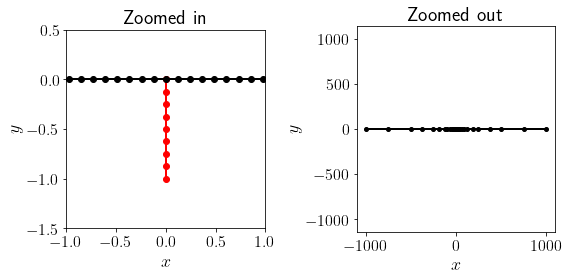

In [48]:
surf_half_L = 1000
t = sympy.var("t")
fault, free = refine_surfaces(
    [(t, t * 0, (t + 1) * -0.5), (t, -t * surf_half_L, 0 * t)],
    gauss_rule(8),
    control_points=np.array([(0, 0, 10, 0.2)]),
)
print(
    f"The free surface mesh has {free.n_panels} panels with a total of {free.n_pts} points."
)
print(
    f"The fault mesh has {fault.n_panels} panels with a total of {fault.n_pts} points."
)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Zoomed in")
plt.plot(fault.panel_edges[:, 0], fault.panel_edges[:, 1], "r-o")
plt.plot(free.panel_edges[:, 0], free.panel_edges[:, 1], "k-o")
plt.axis("scaled")
plt.xlim([-1, 1])
plt.ylim([-1.5, 0.5])
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.subplot(1, 2, 2)
plt.title("Zoomed out")
plt.plot(free.panel_edges[:, 0], free.panel_edges[:, 1], "k-o", markersize=4)
plt.axis("equal")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.tight_layout()
plt.show()


## Solving for surface displacement

The first step in solving the problem is to calculate the surface displacement given unit slip on the fault. To do this, we are going to invert the relevant integral equation. 

The governing integral equation here is:

\begin{equation}
u_z(x) = -\int_{S} \frac{\partial G(x, y)}{\partial y} u_z(y) dy  ~~~~~~~~~~~~~ \forall x \in \Omega / \partial\Omega
\end{equation}

where $G(x, y)$ is the fundamental solution of the Laplace equation, $u_z(y)$ is the slip at point $y$, $\Omega$ is the domain of interest (the Earth!) and $\partial \Omega$ is the boundary of the domain (the free surface **and** the fault) and $u(x)$ is the displacement that we would like to calculate. Finally, $x$ is restricted to lie in the interior of the domain.

To get to something that we can solve numerically to recover, we need a few steps:
1. Separate the surface into two portions: the free surface and the fault.
2. Model the fault as two co-located surface with a jump in displacement.
3. Take the limit as $x$ approaches the free surface.

The result is:

\begin{equation}
u_z(x) = -\lim_{\hat{x} \to x}\int_{H} \frac{\partial G(\hat{x}, y)}{\partial y} u_z(y) dy -\int_{F} \frac{\partial G(x, y)}{\partial y} \Delta u_z(y) dy  ~~~~~~~~~~~~~ \forall x \in H
\end{equation}

where $H$ is the free surface, $F$ is the fault, $\Delta u_z(y)$ is fault slip.

In partially discretized form where we've decomposed the displacement and slip fields into basis functions, the resulting linear system will look like:

\begin{align}
u_i = -A_{ij}u_j - B_{ij}(\Delta u)_j \\

A_{ik} = \lim_{\hat{x} \to x_i}\int_{H} \frac{\partial G(\hat{x}, y)}{\partial y} \psi_k(y) dy \\ 

B_{ij} = \int_{F} \frac{\partial G(x_i, y)}{\partial y} \phi_j(y) dy\\

u(x) = \sum_{i} u_i \psi_i(x)\\
\Delta u(x) = \sum_{i} (\Delta u)_i \phi_i(x)\\
\end{align}

Since we want to calculate the unknown surface displacement $u_i$ from the known slip $(\Delta u)_j$, we can rearrange the linear system to:
\begin{equation}
(I + A_{ij})u_j = -B_{ij}(\Delta u)_j
\end{equation}

The remaining task is to compute the matrices $A$ and $B$ and then invert the left hand side of this linear system.



### Implementation

To construct these matrices, we will use the `integrate_term` function. `integrate_term` takes as parameters:
1. The kernel function. In this case, the integral of $\frac{\partial G(x,y)}{\partial y}$ is also known as the "double layer" potential in classical potential theory because it represents the effect of two co-located sheets of oppositely charged particles. Beyond the mathematical correspondence, this also maps nicely in a conceptual sense to our setting: the double layer potential represents the effect of a jump in displacement across a surface (the fault!). 
2. The observation points. Since we want to calculate the displacement at the free surface, we pass the nodes of the free surface mesh as the observation points: `free.pts`. Note that because these points are on the boundary of the domain, the integrals are computed as limits to the boundary $\hat{x} \to x$. 
3. A flexible number of source surfaces. The numerical integration is much easier if we can handle all the relevant surfaces at once in the form of the original governing equation before we had separated the free surface and fault. `integrate_term` will automatically separate the subcomponents of the resulting matrix 
4. The direction for any limits to the boundary. In this case, we want to approach the boundary from the interior, so we pass `limit_direction=1.0`. If we had wanted to approach the boundary from the exterior, we could pass `limit_direction=-1.0`.
5. Any singularities. See below for more details.
6. Whether to return a report on the internal details of the integration process. See the later section of debugging integration for details on the values that are returned as part of the report. 

`integrate_term` will return a list of matrices. Each matrix will have the shape:
```
(number of observation points, kernel dimension, number of source coefficients)
``` 

In the case of the double layer potential, the kernel dimension is 1, so you might notice a few places where we index the matrices as `mat[:,0,:]`. This is simply to get rid of that middle dimension.


#### Details on singularities

The model has stress singularities. This is generally a sign that you should reconsider your modeling choices, but in this case it's okay because we're trying to match an existing analytical solution. Computing integrals near singularities in the solution is quite difficult. However, `integrate_term` will do its best to handle those singularities. For optimal accuracy, you can specify the location of the singularities. Preferably, we will also specify the location of any "possible singularities" as well. 

**What is a possible-singularities?** Any given point will only be a singularity for some choices of slip field.  For example, the fault tip will produce a stress singularity for any slip distribution that is non-zero at the tip. But, if the slip field happens to be exactly zero at the fault tip, then there is no singularity. This is uncertainty is irrelevant to the integration algorithm because the algorithm is producing a matrix that can be used for arbitrary slip distributions. So, to handle the general case, it's important to assume that any "possible singularity" will be an actual singularity.

In this model, there is a possible-singularity that turns out not to be a singularity: the fault-surface intersection. Here, either the step function in the surface displacement or the nonzero fault tip slip would cause a stress singularity on its own. But, when combined the singularities produced by these two features exactly cancel, leaving behind an entirely non-singular displacement field.

In [49]:
%%time
# Specify singularities
singularities = np.array([
    [-surf_half_L,0],
    [surf_half_L,0],
    [0,0],
    [0,-1],
])

# Integrate!
(surf_disp_to_surf_disp, fault_slip_to_surf_disp), reports = integrate_term(
    double_layer,
    free.pts, 
    free,
    fault,
    limit_direction=1.0,
    singularities=singularities,
    return_report=True
)


# Specify a constant unit slip along the fault.
slip = np.ones(fault.n_pts)

# rhs = B \Delta u
rhs = -fault_slip_to_surf_disp[:,0,:].dot(slip)

# lhs = I + A
lhs = np.eye(free.n_pts) + surf_disp_to_surf_disp[:,0,:]

surf_disp = np.linalg.solve(lhs, rhs)

CPU times: user 2.08 s, sys: 201 ms, total: 2.28 s
Wall time: 322 ms


Not too much code! Now that we've solved for surface displacement, let's check against the classic arctan screw dislocation solution! I'll make two plots. One will show the nearfield displacement and accuracy. The other will show the (very) farfield displacement and accuracy. We're getting 14 digits of accuracy in the nearfield, almost machine precision and 10-11 digits in the farfield. This is from solving the integral equation with ~200 eighth order panels and in less than half a second of runtime! 

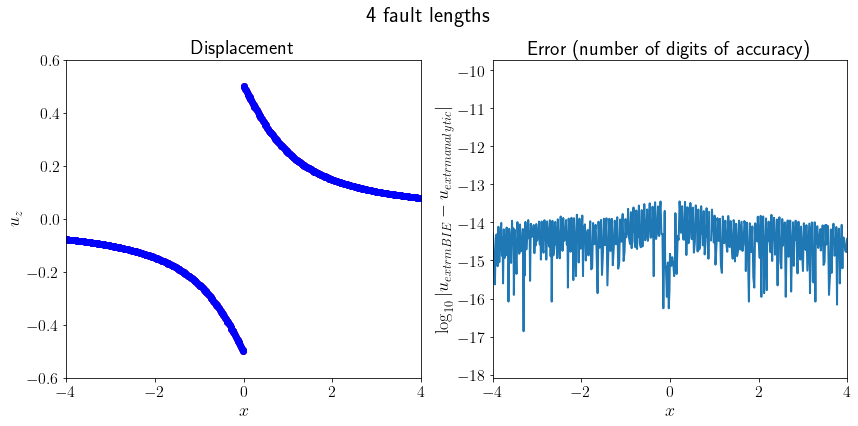

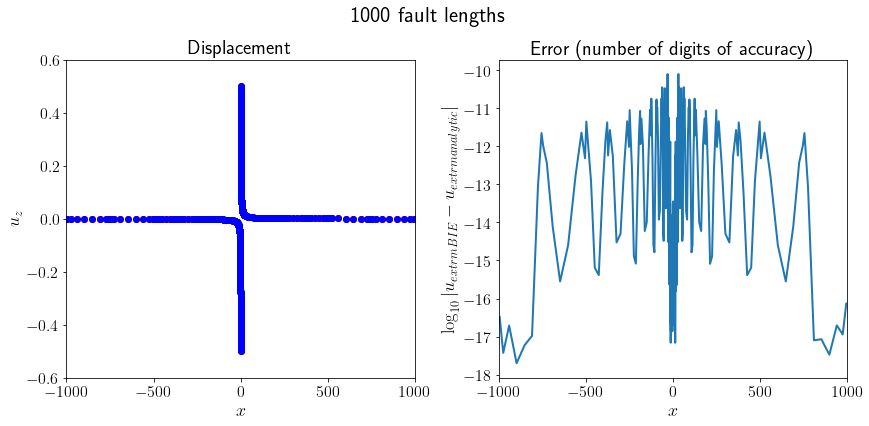

In [50]:
analytical = -np.arctan(-1 / free.pts[:,0]) / np.pi
%matplotlib inline
for XV in [4, 1000]:
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"{XV} fault lengths")
    plt.subplot(1, 2, 1)
    plt.plot(free.pts[:, 0], surf_disp, "ro")
    plt.plot(free.pts[:, 0], analytical, "bo")
    plt.xlabel("$x$")
    plt.ylabel("$u_z$")
    plt.title("Displacement")
    plt.xlim([-XV, XV])
    plt.ylim([-0.6, 0.6])

    plt.subplot(1, 2, 2)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.plot(free.pts[:, 0], np.log10(np.abs(surf_disp - analytical)))
    plt.xlabel("$x$")
    plt.ylabel("$\log_{10}|u_{\textrm{BIE}} - u_{\textrm{analytic}}|$")
    plt.title("Error (number of digits of accuracy)")
    plt.tight_layout()
    plt.xlim([-XV, XV])
    plt.show()

## Interior evaluation of displacement and stress.

Now that we've solved for surface displacement, we have everything we need to evaluate displacement and stress in the interior of the domain. We'll start by producing a grid of observation points near the fault.

In [7]:
nobs = 200
zoomx = [-1.5, 1.5]
zoomy = [-3, 0]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)
obsx = obs_pts[:, 0]
obsy = obs_pts[:, 1]

Next, we'll build the relevant integral equation matrices. To calculate displacement, we'll return to the original integral equation and basically just directly integrate it using `integrate_term`.

\begin{equation}
u_z(x) = -\int_{H} \frac{\partial G(x, y)}{\partial y} u_z(y) dy -\int_{F} \frac{\partial G(x, y)}{\partial y} \Delta u_z(y) dy  ~~~~~~~~~~~~~ \forall x \in \Omega / \partial\Omega
\end{equation}

The `integrate_term` call will hopefully look very familiar. Except for the list of observation points, it's exactly the same as the call from solving for surface displacement. After constructing the matrices, we will multiply them by surface displacement and slip respectively to compute interior displacement.  

In [22]:
K = double_layer
(free_to_disp, fault_to_disp), report = integrate_term(
    double_layer,
    obs_pts,
    free,
    fault,
    singularities=singularities,
    return_report=True,
)
interior_disp = free_to_disp[:, 0, :].dot(surf_disp) + fault_to_disp[:, 0, :].dot(slip)

Calculating stress requires computing the derivatives of the displacement. Numerical differentiation is notoriously error prone, so instead, we'll analytically differentiate the integral equation:

\begin{align}
\sigma_{1z}(x) = -\int_{H} \frac{\partial^2 G(x, y)}{\partial x_1 \partial \textbf{y}} u_z(y) dy -\int_{F} \frac{\partial^2 G(x, y)}{\partial x_1 \partial \textbf{y}} \Delta u_z(y) dy \\
\sigma_{2z}(x) = -\int_{H} \frac{\partial^2 G(x, y)}{\partial x_2 \partial \textbf{y}} u_z(y) dy -\int_{F} \frac{\partial^2 G(x, y)}{\partial x_2 \partial \textbf{y}} \Delta u_z(y) dy
\end{align}

The result is that we can perform a very similar integration but with the double layer kernel replaced with the $\frac{\partial^2 G(x, y)}{\partial x_k \partial \textbf{y}}$. The new kernel is called the "hypersingular" kernel because of the $\frac{1}{r^2}$ dominant behavior of the kernel. The `integrate_term` is the same as the displacement calculation but with the `hypersingular` kernel. The other difference is that the kernel dimension is 2 instead of 1 because there are two stres because there are two stress components.

In [21]:
(free_to_stress, fault_to_stress), report = integrate_term(
    hypersingular,
    obs_pts,
    free,
    fault,
    singularities=singularities,
    return_report=True,
)
interior_stress = free_to_stress.dot(surf_disp) + fault_to_stress.dot(slip)
interior_sxz = interior_stress[:, 0]
interior_syz = interior_stress[:, 1]

Finally, we'll compare with the analytical solutions for both displacement and stress. We're achieving 9 digits of accuracy at a minimum with even better accuracy closer to the free surface and fault!


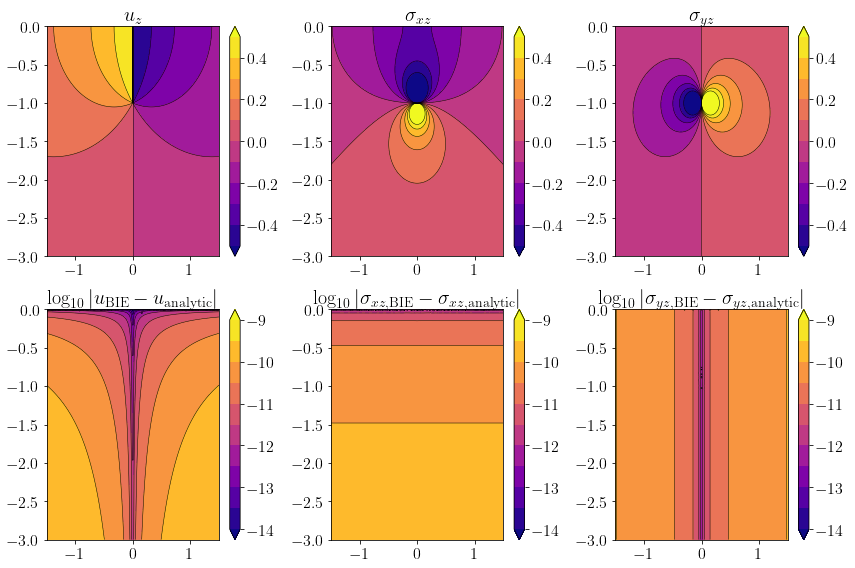

In [18]:
analytical_disp = (
    -1.0 / (2 * np.pi) * (np.arctan((obsy + 1) / obsx) - np.arctan((obsy - 1) / obsx))
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    disp_err = np.log10(np.abs(interior_disp - analytical_disp))

rp = obsx ** 2 + (obsy + 1) ** 2
ri = obsx ** 2 + (obsy - 1) ** 2
analytical_sxz = -(1.0 / (2 * np.pi)) * (((obsy + 1) / rp) - ((obsy - 1) / ri))
analytical_syz = (1.0 / (2 * np.pi)) * ((obsx / rp) - (obsx / ri))
sxz_err = np.log10(np.abs(interior_sxz - analytical_sxz))
syz_err = np.log10(np.abs(interior_syz - analytical_syz))
plt.figure(figsize=(12, 8))

plots = [
    ("analytical_disp", "$u_z$"),
    ("analytical_sxz", "$\sigma_{xz}$"),
    ("analytical_syz", "$\sigma_{yz}$"),
    ("disp_err", r"$\log_{10}|u_{\textrm{BIE}} - u_{\textrm{analytic}}|$"),
    ("sxz_err", r"$\log_{10}|\sigma_{xz,\textrm{BIE}} - \sigma_{xz,\textrm{analytic}}|$"),
    ("syz_err", r"$\log_{10}|\sigma_{yz,\textrm{BIE}} - \sigma_{yz,\textrm{analytic}}|$")
]
for i, (k, title) in enumerate(plots):
    plt.subplot(2, 3, 1 + i)
    plt.title(title)
    v = locals()[k].reshape((nobs, nobs))
    v2d = v.reshape((nobs, nobs))
    if i < 3:
        levels = np.linspace(-0.5, 0.5, 11)
    else:
        levels = np.linspace(-14, -9, 11)
    cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
    plt.contour(
        xs,
        ys,
        v2d,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.colorbar(cntf)
    # plt.xlim([-0.01, 0.01])
    # plt.ylim([-0.02, 0.0])

plt.tight_layout()
plt.show()


## Tools for debugging the integration algorithm

In this final section, I'll show some of the details that come from the reports produced by the integration algorithm. The figures below are useful for debugging and understanding the integration algorithm. A quick summary of each figure:
- `p_all`: This shows the QBX expansion order used for each interior point. The dark blue indicates zero expansion order which means that QBX was not used for those points. 
- `n_subsets`: The shows the number of adaptive integration steps that were taken in accurately integrating the QBX expansions. For example, if the integration interval `[-1, 1]` is split into three subsets: `[-1, 0], [0, 0.5], [0.5, 1]`, then `n_subsets = 3`.
- `direction`: The shows the direction that the expansion center was offset from the nearby source surface with respect to the nearest source surface normal vector. So, `direction = 1` indicates that the expansion center for that observation is offset in the direction of the normal and `direction = -1` indicates that the expansion center was offset in the direction opposite the normal vector.
- `on_surface`: This field is equal to 1 if the point is lying exactly on the nearest source surface.
- `closest_src_pts`: This field shows the `(x, y)` coordinates of the nearest source surface point. 

The `p_all` and `n_subsets` fields are particularly useful for understanding what is happening when a integral is failing to be computed properly. 

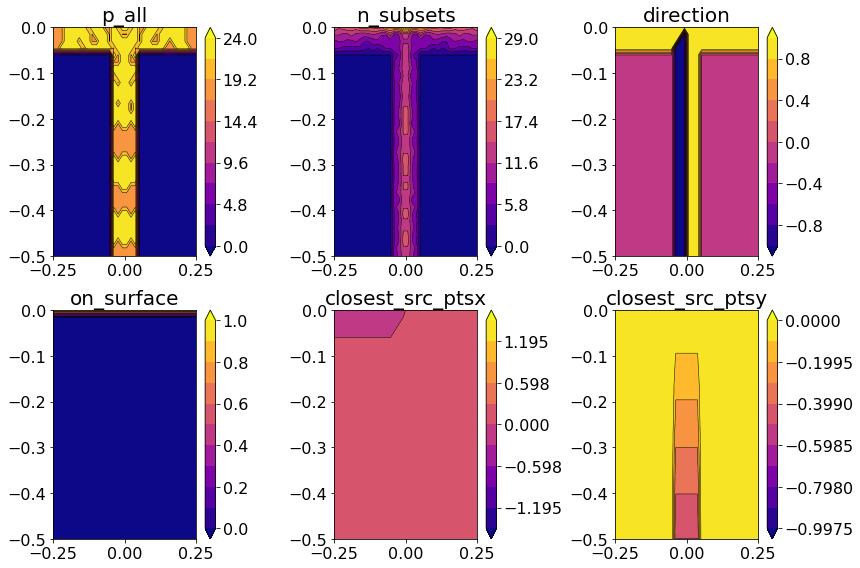

In [25]:
def quick_plot(k):
    plt.title(k)
    v = globals()[k].reshape((nobs, nobs))
    levels = np.linspace(np.min(v), np.max(v), 11)
    cntf = plt.contourf(xs, ys, v, levels=levels, extend="both")
    plt.contour(
        xs,
        ys,
        v,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.colorbar(cntf)


n_subsets = np.zeros(obs_pts.shape[0])
n_subsets[report["use_qbx"]] = report["n_subsets"]

p_all = np.zeros(obs_pts.shape[0])
p_all[report["use_qbx"]] = report["p"]

direction = np.zeros(obs_pts.shape[0])
direction[report["use_qbx"]] = report["direction"]

on_surface = np.zeros(obs_pts.shape[0])
on_surface[report["use_qbx"]] = report["on_surface"]

closest_src_pts = np.zeros((obs_pts.shape[0], 2))
closest_src_pts[report["use_qbx"]] = report["closest_src_pts"]
closest_src_ptsx = closest_src_pts[:, 0]
closest_src_ptsy = closest_src_pts[:, 1]

plt.rcParams['text.usetex'] = False
plt.figure(figsize=(12, 8))
for i, k in enumerate(
    [
        "p_all",
        "n_subsets",
        "direction",
        "on_surface",
        "closest_src_ptsx",
        "closest_src_ptsy",
    ]
):
    plt.subplot(2, 3, 1 + i)
    quick_plot(k)
    plt.xlim([-0.25, 0.25])
    plt.ylim([-0.5, 0])
plt.tight_layout()
plt.show()
plt.rcParams['text.usetex'] = True


These figures are showing the expansion centers and radii at the fault-surface intersection and at the fault tip. 
- The black dots showing the expansion center and the black circles show the radius of accuracy for those expansion centers.
- The blue dots show the observation points where we are evaluating stress. These always lie on one of the expansion circles. This is intentional because it allows the expansion center to be maximally far from any source surface.
- The red lines and dots show the source surfaces: the free surface and the fault.

These figures can be useful for identifying expansion centers/radii that are incorrect. The two criterion for expansion circles are that:
1. They do not intersect the source surfaces at more than the one point where they touch but do not cross. This criterion is not strictly required and a small deviation is okay but seeing an expansion center intersecting a source surface at more than just a touching point is an indication of potential problems.
2. The circle must be 3 times it's radius away from any singular point specified in the `singularities` list above. In these figures, you can see that the expansion radii get quite small near the fault tip and the fault surface intersection.

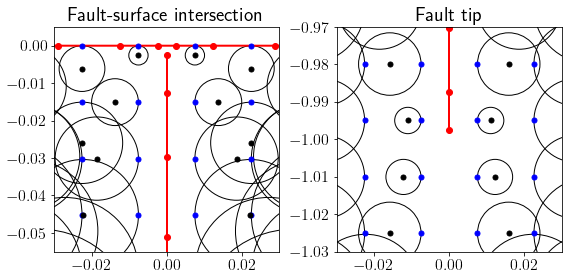

In [27]:
cs = report["exp_centers"]
rs = report["exp_rs"]
plt.figure(figsize=(8, 4))
for i, V in enumerate([(0, -0.025), (0, -1)]):
    plt.subplot(1, 2, 1 + i)
    plt.title("Fault-surface intersection" if i == 0 else "Fault tip")
    W = 0.03
    xrange = [V[0] - W, V[0] + W]
    yrange = [V[1] - W, V[1] + W]
    plt.plot(fault.pts[:, 0], fault.pts[:, 1], "r-o")
    plt.plot(free.pts[:, 0], free.pts[:, 1], "r-o")
    plt.plot(obs_pts[:, 0], obs_pts[:, 1], "b.", markersize=10)
    plt.plot(cs[:, 0], cs[:, 1], "k.", markersize=10)
    for i in range(cs.shape[0]):
        in_x_range = (
            cs[i, 0] - rs[i] < xrange[1] and cs[i, 0] - rs[i] > xrange[0]
        ) or (cs[i, 0] + rs[i] > xrange[0] and cs[i, 0] + rs[i] < xrange[1])
        in_y_range = (
            cs[i, 1] - rs[i] < yrange[1] and cs[i, 1] - rs[i] > yrange[0]
        ) or (cs[i, 1] + rs[i] > yrange[0] and cs[i, 1] + rs[i] < yrange[1])
        if in_x_range and in_y_range:
            plt.gca().add_patch(plt.Circle(cs[i], rs[i], color="k", fill=False))
    plt.axis("scaled")
    plt.xlim(xrange)
    plt.ylim(yrange)
plt.tight_layout()
plt.show()


It's also useful to examine cases where the expansion order is very high or the number of adaptive integration subsets is very high. These could indicate either integration failures or mistaken convergence conditions.

In [28]:
print("p really high in", np.sum(report["p"] > 40), "cases")
print(
    "maximum number of subsets required by adaptive integration: ",
    report["n_subsets"].max(),
)


p really high in 0 cases
maximum number of subsets required by adaptive integration:  29
